In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Set preallocation MEM
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".75"

# Deallocate memory that is no longer needed
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [3]:
from typing import Any, Callable, NamedTuple, Tuple, Union
Step = int
Schedule = Callable[[Step], float]
from PlaceDB import PlaceDB
from IPython import display
from IPython.display import Image, clear_output
from PIL import Image
import glob, os, shutil
import os.path
import sys
import time
import math
import pickle
import scipy.io as io
from scipy import sparse as sp
import scipy.sparse.csgraph as csgraph
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
#import scipy as sp
from scipy.stats import gaussian_kde
from scipy.linalg import null_space

import jax
from jax import jit, vmap, random, grad, value_and_grad, hessian
from jax.experimental import optimizers, sparse
from jax.experimental.optimizers import optimizer
from jax import numpy as jnp

from functools import partial
import itertools

import math
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import collections as mc

import seaborn as sns

import datetime
from tqdm.notebook import tqdm

import networkx as nx

%load_ext autoreload
%autoreload 2

# print full array
np.set_printoptions(threshold=sys.maxsize)

# Restart kernal to apply GPU or CPU
PLATFORM = 'gpu'

# Check if GPU is enabled
jax.config.update('jax_platform_name', PLATFORM)
y = jax.device_put(np.arange(5), device=jax.devices(PLATFORM)[0])
print(y.device_buffer.device())
print(jax.default_backend())

/home/yuw/anaconda3/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


gpu:0
gpu


In [4]:
#from jax.config import config
#config.update("jax_enable_x64", True)

In [5]:
import utils
from utils import *
from optimizers import *

In [6]:
# load the data from the SuiteSparse Matrix Collection format
# https://www.cise.ufl.edu/research/sparse/matrices/
graphs = ['qh882','dwt_1005','3elt','commanche_dual','bcsstk31']
graphdir = './testcases/'
graphpostfix = '3elt'
assert graphpostfix in graphs
grid_testcase = nx.grid_graph(dim=(50, 50))
#grid_testcase = nx.triangular_lattice_graph(25,25)
#grid_testcase = nx.cycle_graph(100)
grid_testcase_adjacency = nx.adjacency_matrix(grid_testcase).toarray().astype(np.int16)
DEBUG=True
if DEBUG:
    graph, ___, ___, L, ___, n = load_graph(graphdir+graphpostfix, A=grid_testcase_adjacency, plot_adjacency=False, verbose=True)
else:
    graph, G, A, L, D, n = load_graph(graphdir+graphpostfix, A=None, plot_adjacency=False, verbose=True)

VLSI=False
if VLSI:
    edgeweight, edges, num_nodes_total, num_movable_nodes, num_nodes = utils.VLSI_import(dname='adaptec1', file_dir='VLSI_testcases/')
    A = sp.csr_matrix((edgeweight, (edges[0], edges[1])), shape=(num_nodes_total+1, num_nodes_total+1))
    D = sp.diags(np.array(A.sum(1)).flatten())
    L = D - A
    n = L.shape[0]


Graph with 2500 nodes and 4900 edges


In [7]:
# del G
# del A
# del D
print(type(L))
print(type(graph))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csc.csc_matrix'>


In [8]:
#@jit
def project(X1, C, E_0, c=jnp.array([0,0])):
    C1 = X1.T@X1
    print('C1 type:\n',type(C1))
    print('C1 value:\n',C1)
    C1sqrt = utils._sqrtm(C1)
    Csqrt = utils._sqrtm(C)
    U,__,V = jnp.linalg.svd(Csqrt@C1sqrt)
    X = X1@jnp.linalg.inv(C1sqrt)@U@V.T@Csqrt
    
    # negdef = jnp.all(jnp.linalg.eigvals(X.T@E_0) <= 1e-6)
    U_E, _, V_E = jnp.linalg.svd(X.T@E_0)
    X = X@(-U_E@V_E.T)
    """
    negdef = jnp.all(jnp.linalg.eigvals(X.T@E_0) <= 1e-6)

    U_E, _, V_E = jnp.linalg.svd(X.T@E_0)
    X = jax.lax.cond(negdef,
                     lambda _ : -X@(U_E@V_E.T),
                     lambda _ : X,
                     operand=None
                    )
    negdef = jnp.all(jnp.linalg.eigvals(X.T@E_0) <= 1e-6)
    """
    return X

@partial(jit, static_argnums=(3,))
def step(i, opt_state, Z, opt_update):
    """Perform a single descent + projection step with arbitrary descent direction."""
    return opt_update(i, Z, opt_state)

def _D_Z(X, A, d, e):
    I = jnp.eye(A.shape[0])
    Ad = A + d*I
    
    Del = jnp.linalg.solve(X.T@jnp.linalg.solve(Ad, X), X.T)@jnp.linalg.solve(Ad, e)
    Z = jnp.linalg.solve(Ad, -X@Del + e)
    
    return Del, Z

def Adpsolve(A, b, M=None, **kwargs):
    """ Solver for linear system As@x = b
    Args:
        b: result of the matrix system
        **kwargs: take an arbitrary number of keyword arguments
    Returns:
        solution x of the matrix system As@x = b
    """     
    # print('Adpsolve')
    res = jax.scipy.sparse.linalg.cg(A, b, M=M, **kwargs)[0]
    # check if output is nan
    # assert not np.isnan(np.sum(res))
    return res

'''
    A: <class 'jax.experimental.sparse.bcoo.BCOO'>
    P: <class 'NoneType'>
    d: <class 'jaxlib.xla_extension.DeviceArray'>
    e: <class 'jaxlib.xla_extension.DeviceArray'>
    I: <class 'jax.experimental.sparse.bcoo.BCOO'>
'''

def sp_diag(M):
    m, n = M.shape
    diag = jnp.zeros(m)

    diag_idx = M.indices[:,0]==M.indices[:,1]
    # print('M.indices[diag_idx]: ', M.indices[diag_idx])
    # print('M.data[diag_idx]: ', M.data[diag_idx].shape)
    # diag = jnp.choose(diag, M)
    idx = jnp.squeeze(M.indices[diag_idx][:2499, :1])
    print(idx)
    data = M.data[diag_idx][:2499]
    diag = diag.at[idx].set(data)
    return diag

def precond(A):
    diag = sp_diag(A)
    n = diag.shape[0]
    M = sparse.BCOO((diag, (jnp.arange(n), jnp.arange(n))), shape=(n,n))
    _precond = lambda x: M@x
    precond = jit(_precond)

    return precond

# TODO convert to JAX
#@jit
def _scipy_D_Z(X, A, P, d, e, I):
    print("inside scipy_D_Z")
    # print('A:', type(A))
    # print('P:', type(P))
    # print('d:', type(d))
    # print('e:', type(e))
    # print('I:', type(I))
    Ad = A + d*I
    print('Ad:', type(Ad))
    # print(Ad.shape)
    
    # linear operator must be either a function or ndarray
    _matvec = lambda x: Ad@x                                                                # Jax version of As/sparse matrix
    matvec = jit(_matvec)
    M = None
    # TODO precond not working
    # M = precond(Ad)
    print('X:', X)
    Del = jnp.linalg.solve(X.T@(Adpsolve(matvec,X,M=M)),X.T)@Adpsolve(matvec,e,M=M)
    # Del = jnp.linalg.solve(X.T@(jnp.linalg.solve(Ad,X)),X.T)@jnp.linalg.solve(Ad,e)
    print('Del:', Del)
    
    v_s = np.ones((A.shape[0],1))/np.sqrt(A.shape[0])
    print('v_s:', v_s)

    XDE = (-X@Del + e)
    print('XDE:', XDE)

    PXDE = XDE - (XDE@v_s)@v_s.T
    print('PXDE:', PXDE)

    # Cause nan at Z
    # ADinvP = Adpsolve(matvec, PXDE)
    sp_solve = lambda A, b:jnp.array(sp.linalg.spsolve(A.astype(np.float64),b.astype(np.float64)))
    Ad = sp.csc_matrix((A.data, (A.indices[:,0], A.indices[:,1])))
    ADinvP = sp_solve(Ad, PXDE)
    print('ADinvP:', ADinvP)

    Z = ADinvP - v_s@(v_s.T@ADinvP)
    
    return Del, Z

def scipy_D_Z(X, A, P, d, e, I):
    Ad = A + d*I
    Ad = sp.csc_matrix((A.data, (A.indices[:,0], A.indices[:,1])))
        
    sp_solve = lambda A, b:jnp.array(sp.linalg.spsolve(A.astype(np.float64),b.astype(np.float64)))
   
    Del = jnp.linalg.solve(X.T@(sp_solve(Ad,X)),X.T)@sp_solve(Ad,e)
    
    v_s = np.ones((A.shape[0],1))/np.sqrt(A.shape[0])
    XDE = (-X@Del + e)

    PXDE = XDE - (XDE@v_s)@v_s.T
    ADinvP = sp_solve(Ad, PXDE)
    Z = ADinvP - v_s@(v_s.T@ADinvP)
    
    return Del, Z

 # Inside newton's method
# Compute A
#@jit
def _sqp(A, L, E_0, X):
    print("inside _sqp")
    """Perform an iteration of SQP.""" 
    w = jnp.linalg.eigvalsh(L)
    print('w:', w)
    idx = w.argsort() 
    w = w[idx]
    E = -E_0 - (A@X + X@L)
    print('E:', E)

    Del_0, Z_0 = _D_Z(X, A, w[0], E[:,0])
    Del_1, Z_1 = _D_Z(X, A, w[1], E[:,1])
    
    Z = jnp.stack([Z_0, Z_1], axis=1)
    Del = jnp.stack([Del_0, Del_1], axis=1)
    return Z, Del  

# Inside ssm method
# Compute PAP
# @jit
def scipy_sqp(X, A, P, L, E_0, I):
    """Perform an iteration of SQP."""
    w = jnp.linalg.eigvalsh(L)
    idx = w.argsort()  
    w = w[idx]
    v = np.ones((A.shape[0],1))/np.sqrt(A.shape[0])
    v = jnp.array(v)
    # print('v:', type(v))

    AX = A@(X - v@(v.T@X))
    # print('AX:', type(AX))

    AX = AX - v@(v.T@AX)
    # print('AX:', type(AX))

    E = -E_0 - (AX + X@L)
    # print('E:', type(E))

    # TODO _scipy_D_Z causes NaN Del and Z
    # Del_0, Z_0 = _scipy_D_Z(X, A, P, w[0], E[:,0], I)
    # Del_1, Z_1 = _scipy_D_Z(X, A, P, w[1], E[:,1], I)
    Del_0, Z_0 = scipy_D_Z(X, A, P, w[0], E[:,0], I)
    Del_1, Z_1 = scipy_D_Z(X, A, P, w[1], E[:,1], I)
    # print('Del_0:', type(Del_0))
    # print('Del_1:', type(Del_1))
    # print('Z_0:', type(Z_0))
    # print('Z_1:', type(Z_1))
    
    Z = jnp.stack([Z_0, Z_1], axis=1)
    Del = jnp.stack([Del_0, Del_1], axis=1)
    
    return Z, Del  

# TODO alpha never used?
def newton(opt_params, A, P, L, C, X_k, b_x, b_y, convergence_criterion, 
           maxiters=100, alpha=1e-2, beta=0.9, initL=True):
    """Perform iterations of PND + backtracking line search."""    
    method_time = time.time()
    opt_state, opt_update, get_params = opt_params
    X_k = get_params(opt_state)
    E_0 = np.stack([b_x, b_y], axis=1)
   
    pAp = P@A@P.T
    
    if initL:
        L = L_init(X_k, C, pAp, E_0)


    #_g = jnp.linalg.norm(g(X_k, jnp.ones((X_k.shape[0],1))/jnp.sqrt(X_k.shape[0]), c=jnp.array([0,0])))
    #_h = jnp.linalg.norm(h(X_k, jnp.eye(X_k.shape[0]), C[0,0], C[0,1], C[1,1], c=jnp.array([0,0])))
    
    report = {'x':None, 'lossh':[f(X_k, pAp, pAp, b_x, b_y)[1].item()], 'sln_path':[np.asarray(X_k)], 
            'foc':[foc_sqp(X_k, L, C, pAp, E_0).item()], 'step_sizes':[1], 'L':[L]}
    
    cc = 0

    def line_search(step_size):
        optt = step(step_size, opt_state, -Z, opt_update)
        xkt = get_params(optt)
        res, t = f(xkt, pAp, pAp, b_x, b_y)
        return res
    
    for k in tqdm(range(maxiters)):
        METHOD_ALT = True
        if METHOD_ALT:
            # Vectorization         
            #Z, Del = sqp(A, P, pAp, L, E_0, X_k)
            Z, Del = _sqp(pAp, L, E_0, X_k)
            print("Z:\n", Z)
            # backtracking line search
            f_xp = jnp.finfo(jnp.float32).max
            #f_x, gr = value_and_grad(f)(X_k, pAp, pAp, b_x, b_y)
            f_x = f(X_k, pAp, pAp, b_x, b_y)[0]
            len_p = jnp.linalg.norm(Z)
            X_k_t = X_k
            
            opt_state_t = opt_state

            # print("*************************RECORDING STEPS*************************")

            """
            1. write a function g(s_k) : s_k (step size) --> f(x, z, s_k)
            2. [s_k^0, s_k^1, s_k^2,..] \in (0,1)
            3. vmap g over []
            """
            # method 1 no for loop
            # method_time = time.time()
            # prevent neg dimension
            # TODO better way to set n?
            # len_p will become nan
            print("len_p:\n", len_p)
            n = abs((math.log(1e-10) - math.log(len_p))/math.log(beta))
            # n = 100
            n = math.ceil(n)
            s_k = np.zeros((n,1))
            for i in range(n):
                s_k[i, :] = math.pow(beta, i+1)
            # jax numpy array s_k
            s_k = jnp.array(s_k)
            vectorize = jax.vmap(line_search, in_axes=0, out_axes=0)
            sk_to_fxp = vectorize(s_k)
            idx = (sk_to_fxp < f_x).argmax()
            _stp = s_k[idx][0]
            # opt state t can be set outside for loop
            opt_state_t = step(_stp, opt_state, -Z, opt_update)
            # print("method 1 --- %s seconds ---" % (time.time() - method_time))
            # print("stp found:\n", _stp)
            print("n:\n", n)
            print("sk_to_fxp:\n", sk_to_fxp)

            L = L - _stp*Del
            
            foc = foc_sqp(X_k, L, C, pAp, E_0)
            # TODO how to return opt_state_t, X_k
            opt_state = opt_state_t
            X_k = get_params(opt_state_t)
            
            report['sln_path'].append(np.asarray(X_k))
            report['step_sizes'].append(_stp)
            report['foc'].append(foc.item())
            # TODO sk_to_fxp sometimes is NaN
            report['lossh'].append(sk_to_fxp[idx])
            report['L'].append(np.asarray(L))   

            if len(report['lossh']) > 2 and np.abs(foc.item()) <= convergence_criterion:
                cc += 1
                if cc > 10:
                    print('converged')
                    break
            if cc > 0:
                cc -= 1
        else:
            # OG method
            Z, Del = _sqp(pAp, L, E_0, X_k)
        
            # backtracking line search
            f_xp = jnp.finfo(jnp.float32).max
            stp = 1
            #f_x, gr = value_and_grad(f)(X_k, pAp, pAp, b_x, b_y)
            f_x = f(X_k, pAp, pAp, b_x, b_y)[0]
            len_p = jnp.linalg.norm(Z)
            X_k_t = X_k
            
            opt_state_t = opt_state
            
            # TODO sometimes loop never started
            t = f_x

            while f_xp >= f_x:
                stp *= beta
                opt_state_t = step(stp, opt_state, -Z, opt_update)
                X_k_t = get_params(opt_state_t)
                f_xp, t = f(X_k_t, pAp, pAp, b_x, b_y)
            
                if stp * len_p < 1e-10:
                    break  

            L = L + stp*Del
            foc = foc_sqp(X_k, L, C, pAp, E_0)
            
            opt_state = opt_state_t
            X_k = get_params(opt_state_t)
            
            report['sln_path'].append(np.asarray(X_k))
            report['step_sizes'].append(stp)
            report['foc'].append(foc.item())
            #report['lossh'].append(f_xp.item())
            report['lossh'].append(t)
            report['L'].append(np.asarray(L))

            #report['h'].append(_h.item())
            #report['g'].append(_g.item())        

            if len(report['lossh']) > 2 and np.abs(foc.item()) <= convergence_criterion:
                cc += 1
                if cc > 10:
                    print('converged')
                    break
            if cc > 0:
                cc -= 1


    print("newton method --- %s seconds ---" % (time.time() - method_time))  
    return report

@jit
def subspace(X_k, Z, v, A, E_0, C):
    v_s = jnp.ones((A.shape[0],1))/np.sqrt(A.shape[0])
    X_k = X_k - v_s@v_s.T@X_k
    AX = A@X_k
    AX = AX - v_s@v_s.T@AX
    
    AXE = AX + E_0
    Z = Z - v_s@v_s.T@Z
    Q, _ = jnp.linalg.qr(jnp.concatenate([X_k, Z, v, AXE],axis=-1), mode='reduced')
    
    return Q

def ssm(opt_params, A, P, L, C, X_0, b_x, b_y, convergence_criterion, 
        maxiters=10, alpha=1e-2, beta=0.9):
    #1. compute newton direction z = sqp(X, Z, v, Ax + E0) & subspace S
    #2. approximate locally optimal X, L on S; X = min F(\hat{X}, B, V.T@E0)
    
    opt_state, opt_init, opt_update, get_params = opt_params
    X_0 = get_params(opt_state)
    v_s = np.ones((A.shape[0],1))/np.sqrt(A.shape[0])
    
    E_0 = jnp.stack([b_x, b_y], axis=1)
    # TODO OOM issue v_s@v_s.T is non sparse
    # print('v_s:', type(v_s), v_s.shape)
    # print(v_s)
    # print('E_0:', type(E_0), E_0.shape)
    PE_0 = E_0 - v_s@(v_s.T@E_0)
    
    # cc = 0
    L = jnp.eye(2)
    results = None

    I = sp.identity(A.shape[0])
    I = sparse.BCOO.from_scipy_sparse(I)

    v = X_0
    
    # M = None
    
    X_0_proj = project(X_0, C, E_0)
    X_k = X_0_proj
    for k in tqdm(range(maxiters)):     
        #print('Subspace computation')
        Z, Del = scipy_sqp(X_k, A, P, L, PE_0, I)
        # Z, Del = _sqp(X_k, A, P, L, PE_0)
        #print('Z orthogonal to V?',Z.T@jnp.array(v_s))

        #print('initialize wrt subspace')
        Q = subspace(X_k, Z, v, A, PE_0, C)
        
        opt_init, opt_update, get_params = psgd(partial(lambda x, y, z: z, 
                                                        E_0, C))    
        QP = Q.T - Q.T@v_s@v_s.T
        QX_k = Q.T@X_k
        QPE_0 = Q.T@PE_0

        opt_state = opt_init(QX_k)  
        result = newton((opt_state, opt_update, get_params), A, QP, L, C, QX_k, QPE_0[:,0], QPE_0[:,1], 
                        convergence_criterion=convergence_criterion, maxiters=20, alpha=0.0, beta=0.9, initL=True) 
        #result = complexopt((opt_state, opt_update, get_params), A, QP, L, C, QX_k, QPE_0[:,0], QPE_0[:,1], 
        #                    convergence_criterion=convergence_criterion, maxiters=100, alpha=0.0, beta=0.9, initL=True)
        
        #X_k = result['sln_path'][-1]
        #L = result['L'][-1]
        X_k = result['sln_path'][np.argmin(result['lossh'])]
        L = result['L'][np.argmin(result['lossh'])]
        
        # TODO X_k becomes NaN at some point
        print('X_k:', X_k)
        print('Q:', Q)
        X_k = Q@X_k
        X_k_p = project(X_k, C, PE_0)
        
        _g = jnp.linalg.norm(g(X_k_p, jnp.ones((X_k.shape[0],1))/jnp.sqrt(X_k.shape[0]), c=jnp.array([0,0])))
        _h = jnp.linalg.norm(h(X_k_p, jnp.eye(X_k_p.shape[0]), C[0,0], C[1,1], C[0,1], c=jnp.array([0,0])))
        
        if results == None:
            results = result
            results['sln_path'] = [X_k]
            results['lossh'] = [result['lossh'][-1]]     
            results['g'] = [_g.item()]
            results['h'] = [_h.item()]  
        
        results['lossh'].extend(result['lossh'])
        results['sln_path'].extend([X_k]*len(result['lossh']))
        results['foc'].extend(result['foc'])
        results['step_sizes'].extend(result['step_sizes'])
        
        results['g'].append(_g.item())
        results['h'].append(_h.item())
        
        result['xinit'] = X_0
        result['projxinit'] = X_0_proj

    return results

In [9]:
def transform_A(A, X_k, boolean_idx):
    boolean_fixed_idx, boolean_nonfixed_idx = boolean_idx
    X_1x = X_k[boolean_fixed_idx,0]
    X_1y = X_k[boolean_fixed_idx,1]
    X_2  = X_k[boolean_nonfixed_idx]
    A_12 = A[boolean_fixed_idx, :]
    A_12 = A_12[:, boolean_nonfixed_idx]
    
    #pap
    A = A[boolean_nonfixed_idx, :]
    A = A[:,boolean_nonfixed_idx]
    
    v_s = np.ones((A.shape[0],1))/np.sqrt(A.shape[0])
    # I = np.eye(v_s.shape[0])
    # pa = A - v_s@(v_s.T@A)
    # pap = pa - (pa@v_s)@v_s.T

    # w,v = nonzero_eig(pap,eps=1e-6)
    #print(w)
    #print(jnp.linalg.norm(pap@v[:,0] - w[0]*v[:,0]),jnp.linalg.norm(pap@v[:,1] - w[1]*v[:,1]))
    # print(v[:,0].sum(), v[:,1].sum())
    v, w = rqi(sparse.BCOO.from_scipy_sparse(A), eps=1e-5, s=0.0)

    #print(w)
    #print(jnp.linalg.norm(pap@v[:,0] - w[0]*v[:,0]),jnp.linalg.norm(pap@v[:,1] - w[1]*v[:,1]))
    print(v[:,0].sum(), v[:,1].sum())
    X_2[:,0] = v[:,0]
    X_2[:,1] = v[:,1]
    
    print('eigenvalues: ', np.round(np.array(w.real), decimals=5))
    #print('eigenvectors: ', np.round(np.array(v.real[:,:5]), decimals=5))
    b_x = X_1x@A_12
    b_y = X_1y@A_12
    
    return A, X_1x, X_1y, X_2, w, b_x, b_y

def map_vars(A, X_k, fixed_idx, centercons, decomp=True):
    """Preprocess variables """ 
    N = A.shape[0] 
    k = fixed_indices.shape[0]
    fixed_idx = jnp.zeros((k,N))

    if VLSI:
        boolean_fixed_idx = np.arange(num_movable_nodes, num_nodes)
        boolean_nonfixed_idx = np.concatenate([np.arange(num_movable_nodes), np.arange(num_nodes, num_nodes_total)])
    else:
        for i in range(k):
            fixed_idx= fixed_idx.at[jnp.index_exp[i, fixed_indices[i]]].add(1)
        boolean_fixed_idx = fixed_idx.sum(0).astype(bool)
        boolean_nonfixed_idx = (1-fixed_idx.sum(0)).astype(bool)
    
    A, X_1x, X_1y, X_2, w, b_x, b_y = transform_A(A, X_k, (boolean_fixed_idx, boolean_nonfixed_idx))
    X_k = X_2
    print('computing constraints null space')
    # constraints = np.expand_dims(np.ones(X_2.shape[0]),0)
    P = None
    n0_x = jnp.zeros_like(b_x)
    if centercons[1] == centercons[0]:
        n0_y = n0_x
    else:
        n0_y = pinvcons@(np.expand_dims(centercons[1],0))
    return X_k, A, P, b_x, b_y, n0_x, n0_y, fixed_idx, w

def cluster(rng, opt_params, X_k, fixed_x, A, mapped_vars, fixed_indices=None, use_fi=False, maxiters=10, convergence_criterion=1e-3,
            c1=1, c2=1, c3=0, centroid=jnp.array([0,0]), centercons=None, v=None, D=None, eps=1e-8, method='pgd'):
    """Given an adjacency matrix A and initialization X_k, optimize X."""
    method = method.lower()
    opt_init, opt_update, get_params = opt_params    
        
    # k = fixed_x.shape[0]
    if not use_fi:
        fixed_coordsx = fixed_x[:,0]
        fixed_coordsy = fixed_x[:,1]
    else:
        fixed_coordsx = X_k[fixed_indices,0]
        fixed_coordsy = X_k[fixed_indices,1]
    
    N = A.shape[0]

    if v is None:
        v = jnp.ones(N)
    #if D is None:
    #    D = jnp.diag(v)
    if centercons is None:
        centercons = jnp.zeros(2)
    A, P, b_x, b_y, n0_x, n0_y, fixed_idx, w = mapped_vars

    C = jnp.block([[c1, c3],[c3, c2]])
    assert jnp.linalg.det(C) > 1e-5
    
    # E_0 = jnp.stack([b_x, b_y], axis=1)
    # n0 = jnp.stack([n0_x,n0_y],axis=0)
    X_k_n = X_k
    print('initial projection')
    #X_k_n = project(X_k_n, C, E_0, centercons)

    L = jnp.eye(2)

    opt_state = opt_init(X_k_n)
    print('ssm...')
    # TODO convert A to scipy.sparse.coo_matrix
    result = ssm((opt_state, opt_init, opt_update, get_params), A, P, L, C, X_k_n, b_x, b_y, 
                    convergence_criterion=convergence_criterion, maxiters=maxiters, alpha=0.0, beta=0.9) 

    X_k = result['sln_path'][np.argmin(result['lossh'])]
    #X_k = result['sln_path'][-1]

    X_k_n = np.zeros((N,2))
    if not use_fi:
        nonfixed_idx = np.ones(N, dtype=bool)
        nonfixed_idx[fixed_indices] = 0
        for i in range(len(result['sln_path'])):
            X_k_t = np.zeros((N,2))
            tmp = result['sln_path'][i]
            X_k_t[fixed_indices,0] = fixed_coordsx
            X_k_t[nonfixed_idx,0] = np.array(tmp[:,0]) + n0_x.T
            X_k_t[fixed_indices,1] = fixed_coordsy
            X_k_t[nonfixed_idx,1] = np.array(tmp[:,1]) + n0_y.T             
            result['sln_path'][i] = X_k_t
            
        X_k_n[fixed_indices,0] = fixed_coordsx
        X_k_n[nonfixed_idx,0] = np.array(X_k[:,0]) + n0_x.T
        X_k_n[fixed_indices,1] = fixed_coordsy
        X_k_n[nonfixed_idx,1] = np.array(X_k[:,1]) + n0_y.T
        
        keys = ['xinit','projxinit']
        for key in keys:
            X_k_t = np.zeros((N,2))
            tmp = result[key]
            X_k_t[fixed_indices,0] = fixed_coordsx
            X_k_t[nonfixed_idx,0] = np.array(tmp[:,0]) + n0_x.T
            X_k_t[fixed_indices,1] = fixed_coordsy
            X_k_t[nonfixed_idx,1] = np.array(tmp[:,1]) + n0_y.T             
            result[key] = X_k_t
        
    else:
        X_k_n[:,0] = np.array(P.T@X_k[:,0]) + n0_x.T
        X_k_n[:,1] = np.array(P.T@X_k[:,1]) + n0_y.T
    
    #result = {}
    result['x'] = X_k_n
    
    mask = (1-fixed_idx.sum(0)).astype(bool)
    result['mask'] = mask
    result['centroid'] = centercons
    result['P'] = (P)
    result['e'] = np.vstack([b_x,b_y])
    result['n'] = (n0_x, n0_y)
    
    return result

In [10]:
##### USER PARAMETERS #####
method = "ssm" # pnd, ssm, or pgd


seed = 0 # random seed
eps = 1e-8 # global epsilon variable
rng = random.PRNGKey(seed)
key, subkey = jax.random.split(rng)

v = np.ones(n)
c1=v.sum()*10**2*1/12
c2=v.sum()*10**2*1/12
c3=0
C = jnp.block([[c1, c3],[c3, c2]])

X_k_r = (random.normal(subkey, (n,2))*np.sqrt(10))
"""
if os.path.isfile(graphdir+graphpostfix+'_evals.npy') and \
   os.path.isfile(graphdir+graphpostfix+'_evecs.npy'):
    w = np.load(graphdir+graphpostfix+'_evals.npy')
    v = np.load(graphdir+graphpostfix+'_evecs.npy')    
else:
    w,v = sp.linalg.eigsh(L, k=min(n,5), which='SM')
    np.save(graphdir+graphpostfix+'_evals.npy',w)
    np.save(graphdir+graphpostfix+'_evecs.npy',v)
if DEBUG:
    w,v = sp.linalg.eigsh(L, k=min(n,5), which='SM')
X_k = v[:,1:3]
"""
X_k = X_k_r

# EXPERIMENTS
# BIAS: (1.) same bias (2.) larger distance from origin

if DEBUG:
    fixed_indices = np.array([0])
else:
    fixed_indices = np.array([0,1,2,3,4,5,6,7,8,9,10])

if VLSI:
    fixed_indices = np.arange(num_movable_nodes, num_nodes)
    nonfixed_indices = np.concatenate([np.arange(num_movable_nodes), np.arange(num_nodes, num_nodes_total)])

#X_k_r[0,0] = 0
#X_k_r[0,1] = -5
X_k_r = X_k_r.at[0,0].set(0)
X_k_r = X_k_r.at[0,1].set(-5)
#X_k[fixed_indices] = X_k_r[fixed_indices]
X_k = np.array(X_k_r)

In [11]:
#del w
#del v
#del X_k_r
v = jnp.ones(n)

print('initial transformation of variables')
#I = sp.identity(L.shape[0])
#L = L+I
#L= L@L

# A here is Laplacian
X_k, A, P, b_x, b_y, n0_x, n0_y, fixed_idx, w = map_vars(L, X_k, fixed_indices, v.sum()*jnp.array([0,0]))

print('done mapping variables')

A = sparse.BCOO.from_scipy_sparse(A)
mapped_vars = (A, P, b_x, b_y, n0_x, n0_y, fixed_idx, w)

opt_init, opt_update, get_params = psgd(partial(lambda x, y, z: project(z, y, x), np.zeros((8,2)), C))       

initial transformation of variables
eigenvalue 1: 0.004
eigenvalue 2: 0.005
0.0 -1.1608005e-05
eigenvalues:  [0.00395 0.00463]
computing constraints null space
done mapping variables


In [12]:
print('clustering...')
result = cluster(rng, (opt_init, opt_update, get_params), 
                 jnp.array(X_k), X_k_r[fixed_indices], L, mapped_vars, fixed_indices=fixed_indices, use_fi=False, c1=c1, c2=c2, c3=c3, centercons=v.sum()*jnp.array([0,0]), 
                 v=None, D=None, eps=1e-8, maxiters=10, convergence_criterion=1e-3, method=method)
results = [result]
X_k_n=result['x']

clustering...
initial projection
ssm...
C1 type:
 <class 'jaxlib.xla_extension.DeviceArray'>
C1 value:
 [[ 9.999999e-01 -9.313226e-09]
 [-9.313226e-09  1.000000e+00]]


  0%|          | 0/10 [00:00<?, ?it/s]

/home/yuw/anaconda3/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:5154: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


  0%|          | 0/20 [00:00<?, ?it/s]

inside _sqp
w: [0.00394654 0.00405394]
E: [[ 1.1392691e+00  9.3667370e-07]
 [-3.3948126e-07 -1.1702724e+00]
 [ 3.6838439e-05  2.0702989e-01]
 [-2.7972499e-05  2.3670630e+00]
 [ 2.6885928e-06 -4.2202950e+00]
 [ 2.1715064e-06 -4.7939342e-02]
 [ 2.1362887e-04  3.7551019e-01]
 [-8.1172620e-06 -5.1334987e+00]]
Z:
 [[-8.3590290e-09 -1.2052982e-07]
 [ 3.5564069e-12  8.3046225e-06]
 [ 2.2082837e-04  1.0449618e+01]
 [-1.0587602e-05  1.4044274e+01]
 [ 2.1453344e-07 -7.8420229e-02]
 [ 3.3125652e-06 -5.1740583e-02]
 [ 7.4965510e-06  1.9962578e-01]
 [-2.5124091e-06 -9.7741924e-02]]
len_p:
 17.50698
n:
 246
sk_to_fxp:
 [117.72442  118.86351  120.37451  122.12794  124.024765 125.99009
 127.96801  129.91756  131.80934  133.6231   135.34549  136.96857
 138.48837  139.90408  141.21695  142.42993  143.54704  144.57304
 145.51309  146.37265  147.15723  147.8722   148.52284  149.11426
 149.65125  150.13832  150.5798   150.97964  151.34154  151.66887
 151.96478  152.23221  152.47375  152.69186  152.8887   1

  0%|          | 0/20 [00:00<?, ?it/s]

inside _sqp
w: [0.00394655 0.00408364]
E: [[ 1.13926995e+00  2.59629132e-07]
 [ 2.01256114e-07 -1.17886817e+00]
 [ 9.67899950e-07  3.81224453e-02]
 [-7.70327659e-08  4.84520793e-02]
 [ 3.22546157e-06 -5.21252155e-02]
 [ 2.53231337e-06  8.96668434e-02]
 [ 4.44056604e-05 -1.98246241e-02]
 [-1.41270375e-05 -3.05458426e-01]]
Z:
 [[-3.9739578e-10  3.0420317e-08]
 [-2.3167904e-10  1.6617723e-05]
 [ 4.0619358e-05  3.2002316e+00]
 [ 1.2242041e-05  1.6696347e+00]
 [ 9.4330462e-06 -2.4905972e-01]
 [-1.7949905e-06  2.3723546e-02]
 [ 9.4201141e-06 -5.0184797e-03]
 [-3.2132477e-06 -1.6017640e-02]]
len_p:
 3.6182919
n:
 231
sk_to_fxp:
 [116.09193  116.10598  116.12096  116.13637  116.15173  116.16687
 116.18147  116.1954   116.20863  116.22108  116.23269  116.24353
 116.25357  116.262825 116.27134  116.27915  116.28631  116.29287
 116.29882  116.30426  116.30921  116.31369  116.31778  116.32149
 116.32484  116.327866 116.33061  116.33312  116.335365 116.337364
 116.3392   116.34086  116.34235  116.3

  0%|          | 0/20 [00:00<?, ?it/s]

inside _sqp
w: [0.00394655 0.00408402]
E: [[ 1.13927126e+00 -7.40834082e-07]
 [-3.15862451e-07 -1.17897940e+00]
 [ 1.55051737e-06  1.00672245e-04]
 [ 9.68288759e-07  1.66647434e-02]
 [ 3.22252254e-06 -7.93457031e-04]
 [ 1.39662419e-07  4.12803888e-03]
 [ 1.22138357e-04 -6.29961491e-04]
 [ 2.51057700e-05 -2.30153799e-02]]
Z:
 [[-1.5104131e-05  1.5626592e-08]
 [-3.8751596e-11  4.3900736e-06]
 [ 7.7181157e-06  7.8227115e-04]
 [ 5.0906812e-05  1.2626868e+00]
 [-1.2124301e-06 -1.5878251e-01]
 [-1.5612168e-06  8.2117818e-05]
 [ 2.3794577e-05 -1.5396770e-04]
 [ 6.6486637e-06 -1.7690085e-03]]
len_p:
 1.2726326
n:
 221
sk_to_fxp:
 [115.95464  115.956215 115.95783  115.95949  115.96106  115.962585
 115.96404  115.965454 115.96675  115.96802  115.96914  115.970184
 115.97117  115.97206  115.97286  115.97365  115.97433  115.97495
 115.97554  115.97607  115.97653  115.976974 115.97734  115.977715
 115.97802  115.97832  115.978584 115.97881  115.97902  115.97922
 115.97941  115.97957  115.97971  115

  0%|          | 0/20 [00:00<?, ?it/s]

inside _sqp
w: [0.00394656 0.00409384]
E: [[ 1.1392726e+00 -1.1574165e-07]
 [-5.2840574e-07 -1.1818159e+00]
 [ 1.9766330e-06 -6.6506863e-04]
 [-1.0745732e-06  6.5471232e-03]
 [ 1.0110582e-06 -4.3225288e-04]
 [-1.4559065e-05 -1.0590553e-03]
 [ 5.4833985e-05 -2.4390221e-04]
 [-7.6870647e-06  4.3824315e-03]]
Z:
 [[ 1.51023387e-05  1.97740917e-08]
 [ 7.70182182e-12  7.94053619e-07]
 [ 2.10379403e-05 -6.38662577e-02]
 [-1.00172634e-04  4.99479771e-01]
 [ 7.55897599e-06 -2.45966185e-02]
 [-5.41276859e-06 -6.95315684e-05]
 [ 9.92609966e-06 -3.76819080e-05]
 [-2.16645094e-06  6.92420756e-04]]
len_p:
 0.5041472
n:
 213
sk_to_fxp:
 [115.935234 115.93548  115.93574  115.936    115.93624  115.93647
 115.93673  115.93695  115.93715  115.937325 115.93757  115.93771
 115.93784  115.93796  115.93811  115.93822  115.93837  115.93846
 115.93852  115.93859  115.93866  115.938736 115.93882  115.93886
 115.9389   115.93898  115.939    115.939026 115.93909  115.93909
 115.939125 115.93916  115.939186 115.93

  0%|          | 0/20 [00:00<?, ?it/s]

inside _sqp
w: [0.00394654 0.00409763]
E: [[ 1.1392689e+00  2.2237339e-07]
 [ 5.1936564e-07 -1.1829097e+00]
 [ 1.2342038e-06  2.4270713e-03]
 [-1.0336096e-06  1.4291853e-03]
 [ 3.7842742e-06 -7.1740150e-04]
 [-5.4783713e-06  1.2906194e-03]
 [-1.3739333e-04  5.6028366e-04]
 [ 3.3622814e-06 -7.4533224e-03]]
Z:
 [[-1.4267060e-09 -5.5952150e-09]
 [-1.5208208e-12 -2.1088497e-05]
 [ 2.9168259e-05  1.9372445e-01]
 [ 9.4742236e-06  7.8727715e-02]
 [ 5.9417839e-06 -2.4106834e-02]
 [-3.8866601e-06  1.4425385e-04]
 [-2.6382326e-05  3.6685400e-05]
 [ 9.0932042e-07 -5.1749189e-04]]
len_p:
 0.21049619
n:
 204
sk_to_fxp:
 [115.93168  115.93173  115.931755 115.93184  115.93185  115.931885
 115.93196  115.93195  115.93202  115.93206  115.93206  115.93212
 115.932175 115.9322   115.93218  115.9322   115.93226  115.93224
 115.9323   115.9323   115.9323   115.9323   115.93231  115.932335
 115.93235  115.93237  115.93234  115.932396 115.932396 115.932365
 115.93236  115.93237  115.932396 115.932396 115.932

  0%|          | 0/20 [00:00<?, ?it/s]

inside _sqp
w: [0.00394654 0.00409913]
E: [[ 1.1392688e+00  1.2085130e-07]
 [ 5.4643908e-07 -1.1833419e+00]
 [ 9.7617612e-07  4.1319430e-04]
 [ 6.8508751e-07  9.7322464e-04]
 [ 2.4396552e-06 -1.9955635e-04]
 [-9.2027358e-06  6.4671040e-05]
 [-4.3654334e-05  5.7399273e-05]
 [-2.7103444e-05  1.1446476e-03]]
Z:
 [[-1.5103539e-05  1.9504427e-09]
 [ 7.1742515e-11  4.2670604e-06]
 [ 3.2093776e-05  3.5083186e-02]
 [ 6.2784886e-05  7.4550994e-02]
 [-5.6709728e-06 -7.7019325e-03]
 [-2.9796727e-06  1.7334032e-05]
 [-8.6182245e-06  4.7306598e-06]
 [-7.4618001e-06  1.1139082e-04]]
len_p:
 0.08275276
n:
 195
sk_to_fxp:
 [115.9311   115.93113  115.93112  115.931145 115.931114 115.93115
 115.93111  115.93111  115.931114 115.93116  115.931145 115.93118
 115.93116  115.93117  115.93117  115.931175 115.93119  115.9312
 115.93119  115.93119  115.93117  115.9312   115.931175 115.93117
 115.93115  115.9312   115.9312   115.93118  115.93117  115.9312
 115.9312   115.93118  115.93124  115.93121  115.93119  1

  0%|          | 0/20 [00:00<?, ?it/s]

inside _sqp
w: [0.00394655 0.0040997 ]
E: [[ 1.1392705e+00  1.7188043e-08]
 [-3.3981524e-07 -1.1835083e+00]
 [-2.2071447e-07  4.1434169e-04]
 [ 6.6388820e-06  1.4573336e-04]
 [-1.6509611e-08 -9.2029572e-05]
 [-9.9857798e-06 -9.9658966e-05]
 [ 6.3246509e-05 -3.9935112e-05]
 [ 1.5537127e-05 -6.1154366e-04]]
Z:
 [[-3.0206675e-05 -9.2994912e-10]
 [-5.5334796e-11 -5.3973104e-06]
 [ 9.0545196e-05  3.2795288e-02]
 [ 5.4024760e-05  7.9794973e-03]
 [-1.2403429e-05 -3.4510992e-03]
 [-3.7390848e-06 -7.5876014e-06]
 [ 9.4671886e-06 -2.2690654e-05]
 [ 5.5325918e-06 -4.8863378e-05]]
len_p:
 0.033928286
n:
 187
sk_to_fxp:
 [115.9313   115.93132  115.931274 115.93129  115.931274 115.93129
 115.9313   115.93128  115.931305 115.93129  115.931305 115.93132
 115.931305 115.93128  115.93127  115.93129  115.931274 115.9313
 115.9313   115.93129  115.931305 115.931305 115.93131  115.93128
 115.9313   115.93128  115.9313   115.93128  115.931305 115.93129
 115.931305 115.93128  115.931305 115.93129  115.93131 

  0%|          | 0/20 [00:00<?, ?it/s]

inside _sqp
w: [0.00394655 0.00409994]
E: [[ 1.1392703e+00  3.4853832e-07]
 [ 4.7498980e-07 -1.1835761e+00]
 [-1.7315997e-06  1.6638637e-04]
 [ 9.6148437e-07  5.8919191e-05]
 [ 6.2798249e-06 -2.6702881e-05]
 [ 1.0829231e-05  5.6624413e-06]
 [ 8.3757564e-05  6.0796738e-06]
 [-2.9430823e-05  9.0599060e-05]]
Z:
 [[-1.19189403e-09 -2.00727740e-10]
 [ 4.16935431e-10 -1.03857265e-05]
 [-1.52417793e-04  1.28795840e-02]
 [-4.80537528e-05  4.41082427e-03]
 [ 3.24693101e-05 -1.66551955e-03]
 [ 5.70585371e-06 -2.31252343e-05]
 [ 1.61458447e-05  3.23835593e-06]
 [-1.67618437e-05  4.70319283e-05]]
len_p:
 0.0137165245
n:
 178
sk_to_fxp:
 [115.930984 115.930984 115.93101  115.930984 115.93099  115.931015
 115.931    115.93101  115.93101  115.93099  115.93103  115.93103
 115.93099  115.931    115.931015 115.931015 115.931015 115.93099
 115.931    115.93099  115.93098  115.931015 115.93099  115.93102
 115.931015 115.93099  115.93103  115.93101  115.93102  115.931015
 115.93101  115.93101  115.931015 1

  0%|          | 0/20 [00:00<?, ?it/s]

inside _sqp
w: [0.00394655 0.00410004]
E: [[ 1.1392702e+00  3.9376815e-08]
 [-4.2938731e-07 -1.1836061e+00]
 [-1.1119953e-06  7.7962875e-05]
 [ 6.3294883e-06  3.7640333e-05]
 [-7.2796030e-07 -3.3378601e-05]
 [ 1.3348351e-05  5.3346157e-05]
 [-5.8382619e-05  2.0027161e-05]
 [-1.1144846e-05  2.0018220e-04]]
Z:
 [[-1.51036975e-05  1.60675723e-10]
 [ 3.66481810e-11  6.83885082e-06]
 [ 2.77054423e-05  6.03707833e-03]
 [ 2.28332865e-05  1.37839431e-03]
 [ 8.28201649e-08 -5.06006356e-04]
 [ 6.41856514e-06  3.95810230e-06]
 [-1.00823745e-05  6.50181255e-06]
 [-5.12290171e-06  1.17678383e-05]]
len_p:
 0.0062132324
n:
 171
sk_to_fxp:
 [115.931046 115.93104  115.931015 115.93103  115.93106  115.93102
 115.931015 115.93103  115.931015 115.93102  115.93103  115.93102
 115.93102  115.931015 115.93103  115.93103  115.931015 115.93101
 115.93102  115.93102  115.93104  115.93103  115.93102  115.931015
 115.93103  115.93102  115.93102  115.931015 115.93103  115.93102
 115.93102  115.93103  115.931015 11

  0%|          | 0/20 [00:00<?, ?it/s]

inside _sqp
w: [0.00394654 0.00410008]
E: [[ 1.1392679e+00  1.1884839e-07]
 [ 3.2639985e-08 -1.1836176e+00]
 [-3.7948596e-06  3.3408403e-05]
 [-1.9760699e-05 -8.6426735e-06]
 [ 1.4707964e-06 -4.0531158e-06]
 [ 6.7889146e-06 -5.0663948e-06]
 [ 9.2767077e-05 -4.2319298e-06]
 [-4.1776666e-06 -2.4974346e-05]]
Z:
 [[-1.5104084e-05  8.9717310e-11]
 [-1.0878801e-12  1.4633385e-05]
 [ 7.2598988e-05  2.5798830e-03]
 [-6.3566593e-05 -6.6306500e-04]
 [-1.2504103e-05 -2.6751004e-04]
 [ 1.3574976e-06 -5.1385568e-06]
 [ 1.2073800e-05 -7.4955369e-07]
 [-3.0549321e-09 -3.9914489e-06]]
len_p:
 0.0026790136
n:
 163
sk_to_fxp:
 [115.93091  115.93089  115.93087  115.93091  115.930885 115.930885
 115.93086  115.93085  115.93084  115.930824 115.93085  115.930824
 115.93084  115.930824 115.93084  115.930885 115.930824 115.93084
 115.93085  115.930824 115.93083  115.93083  115.93083  115.93084
 115.93085  115.93082  115.930824 115.930824 115.930855 115.93086
 115.93083  115.93083  115.93084  115.93084  115.93

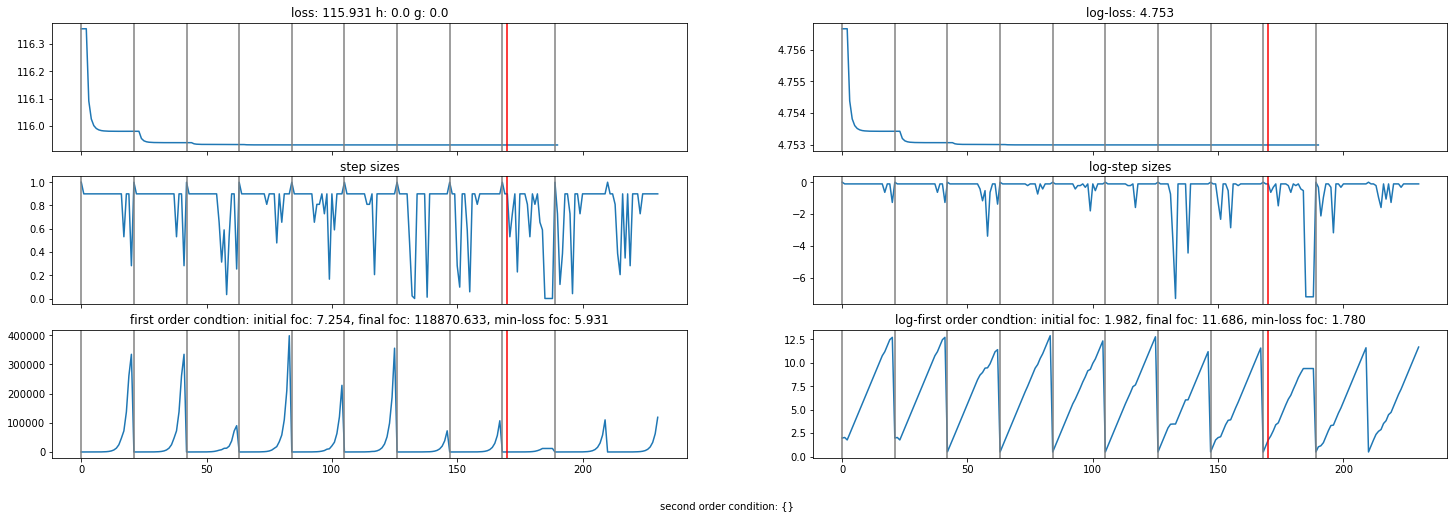

In [13]:
resgraph = utils.plot_results(result)

In [14]:
voxel_id, voxel_bound = voxel_cluster(X_k, np.array([5, 5]))

<AxesSubplot:>

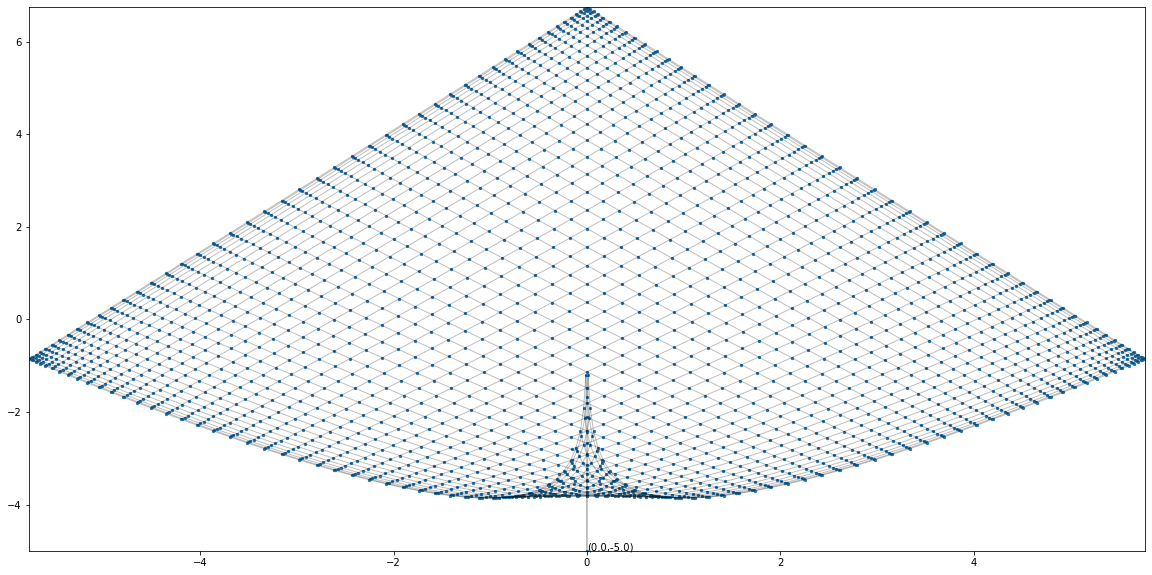

In [15]:
utils.plot_graph(result['projxinit'], graph, title='', fixed_indices=fixed_indices, c=None)

<AxesSubplot:title={'center':'loss: 115.93 h: 0.0 g: 0.0 foc: 5.93'}>

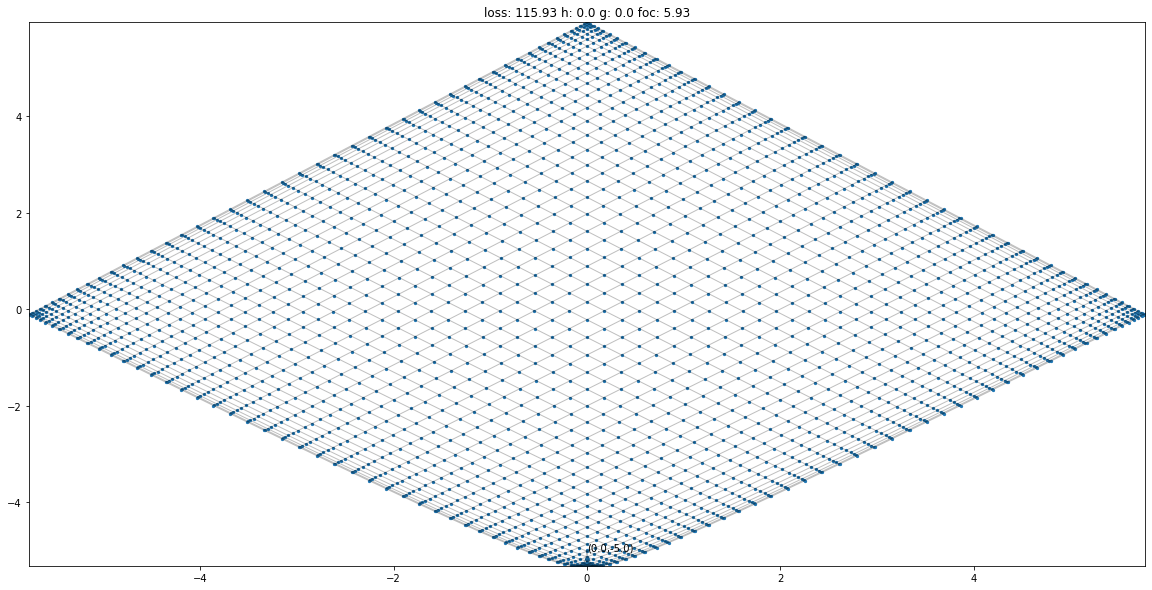

In [16]:
#result['h'] = 0.0
#result['g'] = 0.0
utils.plot_graph(X_k_n, graph, title='loss: {} h: {} g: {} foc: {}'.format(str(np.round(np.min(result['lossh']),2)), 
                                                                            np.round(result['h'][-1],2), np.round(result['g'][-1],2), 
                                                                           str(np.round(result['foc'][np.argmin(result['lossh'])],2))), fixed_indices=fixed_indices, c=None)

In [17]:
import jax.numpy as jnp
a = np.random.rand(3,3)
b = np.random.rand(3,3)

jnp.add(a,b)

DeviceArray([[1.5216527 , 0.15624188, 0.2902497 ],
             [0.44714582, 1.0630283 , 0.7291363 ],
             [0.8865725 , 0.89142203, 0.5500605 ]], dtype=float32)

In [18]:
vectorize = jax.vmap(jnp.add, in_axes=(0,1), out_axes=1)
vectorize(a,b)

DeviceArray([[1.5216527 , 0.44106767, 0.88441   ],
             [0.16232002, 1.0630283 , 1.0810183 ],
             [0.2924122 , 0.53953993, 0.5500605 ]], dtype=float32)

In [19]:
a = np.array(['a', 'b', 'a', 'a', 'b', 'a'])
b = np.array([150, 154, 147, 126, 148, 125])
c = np.zeros_like(b)
c[0] = 150
np.where(a == "b", np.roll(c, 1), b)

array([150, 150, 147, 126,   0, 125])